# Basic Monte Carlo methods

## Takeaways and objectives from this notebook
Understand **importance sampling** as a method to compute expectations of functions with respect to distributions from which we are unable to sample but for which we can compute densities.  Importance sampling allows us to compute the expectations but not draw samples from the distributions of interest.

Understand **rejection sampling**, which is in some sense less efficient than importance sampling but allows us to draw samples from distributions for which we can only compute densities.

**Note**: the most effective sampler from a Normal distribution is a rejection sampler that makes use of the Box-Muller transform.  We will examine the implementation of `numpy.random.randn` to study this method.

## Importance sampling

The key idea of importance sampling is to use a **designed** probability distribution $q(x)$ to compute an estimate of an expectation
of a function $E[f(x)]$ where $x$ is distributed according to a distribution $p(x)$ which we can compute at any point but which we don't know
how to sample.

Assuming we want to evaluate the expectation of a function $h(x)$ with respect to the distribution $p(x)$

$$E[h(x)] = \int h(x) p(x) dx$$

we add the following terms and regroup:

$$E[h(x)] = \int h(x) p(x) dx = \int \frac{h(x)p(x)}{q(x)} q(x) dx = \int w(x) q(x) dx,$$

where

$$w(x) = h(x)p(x)/q(x)$$

can be considered a new 'function' whose expectation we compute with respect to $q(x)$. The fraction $p(x)/q(x)$ is called the **likelihood ratio** and is easily computable under our original assumption of being able to evaluate $p(x)$ anywhere.  Note that for this construction to work, we have to assume that $q(x) > 0$ whenever $f(x)p(x) \neq 0$. Under these conditions our estimate is unbiased, see [more detailed explanation](https://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf).

The last integral can be again approximated with a sum over $x$ drawn from the distribution $q(x)$ from which we can sample (by construction)

$$E[h(x)] \approx \frac{1}{n}\sum_{i=1}^n h(x), \text{where we draw} \; x \sim q(x)$$

### What could go wrong in importance sampling?
- Note that the condition of convergence is simply that $q(x) > 0$ wherever $f(x)p(x) \neq 0$.  However what happens if $q(x) \approx 0$ in a large portion of the region where $f(x)p(x) \neq 0$?  
  - How would you recognize the above situation during sampling?
  - How would you resolve such a situation?
- What happens if you don't obtain enough samples for your estimate?

### Exercise

We are going to estimate the expected value of function $E[x]$, where $x \sim p(x)$, that is the expected value of the distribution $p(x)$.  Here is $p(x)$:

$$p(x) = \sqrt{\frac{1}{8\pi}}\exp(-\frac{(x-3)^2}{2}) + \sqrt{\frac{1}{16\pi}}\exp(-\frac{(x-6)^2}{4}).$$

Below is a function `eval_p` that will evaluate the density of the function at any point $x$.

In [1]:
import numpy as np

# This function definition will also work on lists and np.arrays
def eval_p(x):
    return (1./8/np.pi)**0.5*np.exp(-0.5*(x-3)**2) + (1./16/np.pi)**0.5*np.exp(-0.25*(x-6)**2)

# Note: you can easily evaluate this function for any x but you can't easily sample random numbers
# from it. In Bayesian models, the same happens with data likelihoods.

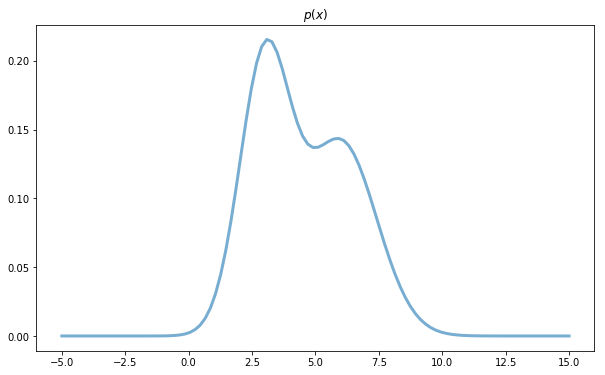

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,6))
ax = fig.gca()
x = np.linspace(-5, 15, 100)
ax.plot(x, eval_p(x), lw=3, alpha=0.6)
plt.title('$p(x)$')
plt.show()

In [3]:
from scipy.stats import norm

# Let's use the normal distribution for the sampling - it will become our q distribution.  However we need to ensure that the space is sampled properly
# Observe that q(x) > 0 everywhere but for the current parameters (mean=0, scale=1) but if you repeat your estimation
# several times, you will see a large variation.  Why is that?
#
# Try to change the standard deviation (scale) around.  What's the effect, when you look at the **estimate_expected_value** plot below?

def designed_q(x):
    return norm.pdf(x, loc=0, scale=1)

def sample_q(size):
    return norm.rvs(loc=0,scale=1,size=size)

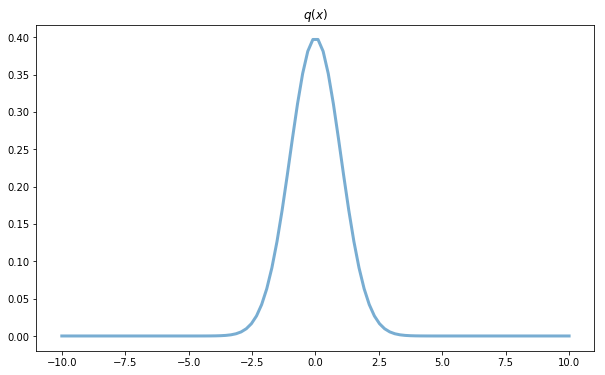

In [4]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
x = np.linspace(-10, 10, 100)
ax.plot(x, designed_q(x), lw=3, alpha=0.6)
plt.title('$q(x)$')
plt.show()

### Importance sampling code
The function below is the core of importance sampling.  It is really that simple in code.  Compare this to the formulation above and convince yourself that the code below computes the required formula.

In [7]:
def estimate_expected_value(n):
    xs = sample_q(n)
    return np.mean([x*eval_p(x)/designed_q(x) for x in xs])

We evaluate the estimate for different number of samples below.

In [6]:
[estimate_expected_value(n=n) for n in [500, 1000, 5000, 10000, 50000, 100000]]

[0.3246288198924269,
 0.4896765760749669,
 1.7433421717847224,
 1.0013896503384365,
 2.611955124783151,
 1.3219867740374547]

### Questions
1. What is your estimate of the expected value?
2. Are you sure? How did you convince yourself you are right?

## Solution

It's possible to obtain the correct value by pasting the formula

$$E[x] = \int_{-\infty}^\infty x p(x) dx$$

into Wolfram Alpha where the formula above is substituted for $p(x)$.  After you compute the your estimate, go ahead and compare it to the true value.

### Issues to think about
- It's possible to computed expected values of functions for distributions that we cannot sample but can only evaluate - for example using importance sampling.
- It's not trivial to tune an importance sampler.
- It's not easy to convince yourself that your estimate is good.  How did you do it?
- How would you add automatic diagnostics to your importance sampler?
- It's always tricky to assess convergence. Bonus exercise: assess the variance of your estimate.

## Rejection sampling

There are some similarities between importance and rejection sampling. Rejection sampling also uses an auxiliary (designed) probabiliy density $q(x)$ to guide the sampling process and the likelihood ratio $p(x)/q(x)$ is important in rejection sampling as well.

However, rejection sampling brings in a key new idea: **not all Monte Carlo samples are accepted, some are rejected.**

We need to assume that we know a value $M \in {\cal R}$ s.t. $\forall x \in {\cal R} \; p(x)/q(x) \leq M$.  Note that the ratio $p(x)/q(x)$ is the **likelihood ratio** we encountered in importance sampling.

## Slice sampling

In rejection sampling, we have to ensure that our designed (and multiplied) density $cq(x)$ dominates the density of interest $p(x)$ everywhere.  This can be difficult, since it's typically the case that we don't know the properties of $p(x)$ since it's our sought after variable.



## Other methods
- Gibbs sampling
